# Train a ConvNet!
We now have a generic solver and a bunch of modularized layers. It's time to put it all together, and train a ConvNet to recognize the classes in CIFAR-10. In this notebook we will walk you through training a simple two-layer ConvNet and then set you free to build the best net that you can to perform well on CIFAR-10.

Open up the file `cs231n/classifiers/convnet.py`; you will see that the `two_layer_convnet` function computes the loss and gradients for a two-layer ConvNet. Note that this function uses the "sandwich" layers defined in `cs231n/layer_utils.py`. 

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifier_trainer import ClassifierTrainer
from cs231n.gradient_check import eval_numerical_gradient
from cs231n.classifiers.convnet import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-18, np.abs(x) + np.abs(y))))


In [2]:
from cs231n.data_utils import load_CIFAR10
# Modify load_CIFAR10 and the following function to load less data if you have memory issues.
# Load batches 1, 2 and 3; and call the function as follows:
#def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
def get_CIFAR10_data(num_training=19000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (19000, 3, 32, 32)
Train labels shape:  (19000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)


# Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [6]:
model = init_two_layer_convnet()

X = np.random.randn(100, 3, 32, 32)
y = np.random.randint(10, size=100)

loss, _ = two_layer_convnet(X, model, y, reg=0)

# Sanity check: Loss should be about log(10) = 2.3026
print 'Sanity check loss (no regularization): ', loss

# Sanity check: Loss should go up when you add regularization
loss, _ = two_layer_convnet(X, model, y, reg=1)
print 'Sanity check loss (with regularization): ', loss

Sanity check loss (no regularization):  2.302562404798755
Sanity check loss (with regularization):  2.344576408183839


# Gradient check
After the loss looks reasonable, you should always use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [7]:
num_inputs = 2
input_shape = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)

model = init_two_layer_convnet(num_filters=3, filter_size=3, input_shape=input_shape)
loss, grads = two_layer_convnet(X, model, y)
for param_name in sorted(grads):
    f = lambda _: two_layer_convnet(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 2.907542e-07
W2 max relative error: 1.027611e-05
b1 max relative error: 8.983732e-08
b2 max relative error: 2.283392e-07


# Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [8]:
# Use a two-layer ConvNet to overfit 50 training examples.

model = init_two_layer_convnet()
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train[:50], y_train[:50], X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=10, num_epochs=10,
          verbose=True)

starting iteration  0
Finished epoch 0 / 10: cost 2.310619, train: 0.120000, val 0.107000, lr 1.000000e-04
Finished epoch 1 / 10: cost 2.245213, train: 0.320000, val 0.154000, lr 9.500000e-05
Finished epoch 2 / 10: cost 2.101079, train: 0.400000, val 0.152000, lr 9.025000e-05
starting iteration  10
Finished epoch 3 / 10: cost 1.981816, train: 0.340000, val 0.138000, lr 8.573750e-05
Finished epoch 4 / 10: cost 1.487980, train: 0.580000, val 0.163000, lr 8.145062e-05
starting iteration  20
Finished epoch 5 / 10: cost 0.929647, train: 0.700000, val 0.203000, lr 7.737809e-05
Finished epoch 6 / 10: cost 0.841536, train: 0.800000, val 0.157000, lr 7.350919e-05
starting iteration  30
Finished epoch 7 / 10: cost 1.180814, train: 0.960000, val 0.183000, lr 6.983373e-05
Finished epoch 8 / 10: cost 0.472976, train: 0.940000, val 0.183000, lr 6.634204e-05
starting iteration  40
Finished epoch 9 / 10: cost 0.323862, train: 0.920000, val 0.190000, lr 6.302494e-05
Finished epoch 10 / 10: cost 0.04936

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

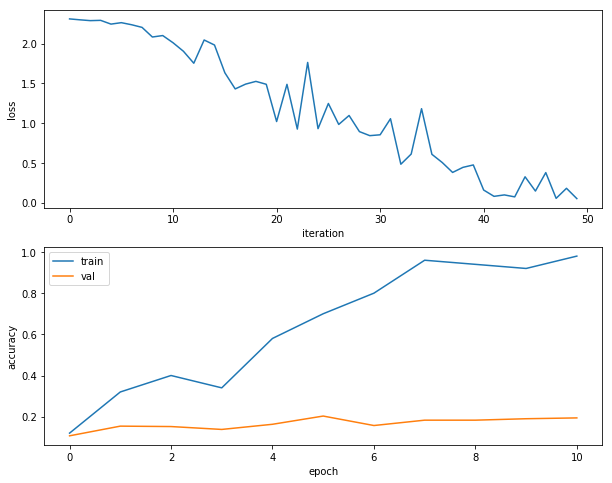

In [9]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Train the net
Once the above works, training the net is the next thing to try. You can set the `acc_frequency` parameter to change the frequency at which the training and validation set accuracies are tested. If your parameters are set properly, you should see the training and validation accuracy start to improve within a hundred iterations, and you should be able to train a reasonable model with just one epoch.

Using the parameters below you should be able to get around 50% accuracy on the validation set.

In [12]:
model = init_two_layer_convnet(filter_size=7)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=50, num_epochs=1,
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 1: cost 2.296869, train: 0.125000, val 0.126000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 1: cost 1.825215, train: 0.343000, val 0.319000, lr 1.000000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 1: cost 1.926565, train: 0.340000, val 0.337000, lr 1.000000e-04
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 1: cost 1.107152, train: 0.374000, val 0.398000, lr 1.000000e-04
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 1: cost 1.890629, train: 0.420000, val 0.395000, lr 1.000000e-04
starting iteration  210
starting iteration  220
starting iteration  230
starting iterat

# Visualize weights
We can visualize the convolutional weights from the first layer. If everything worked properly, these will usually be edges and blobs of various colors and orientations.

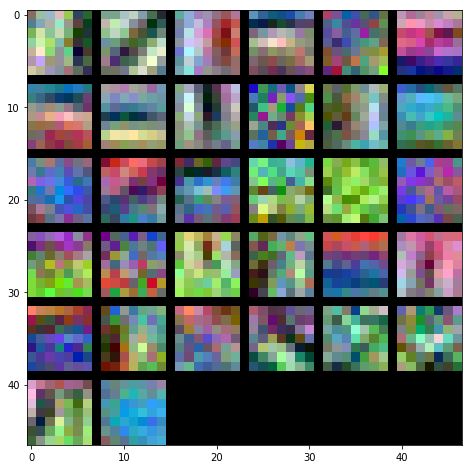

In [13]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))

# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Network depth: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `cs231n/classifiers/convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum and RMSprop; you could try alternatives like AdaGrad or AdaDelta.
- Other forms of regularization such as L1 or Dropout
- Alternative activation functions such as leaky ReLU or maxout
- Model ensembles
- Data augmentation

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

In [3]:
# hyper parameter arrays
best_net = None
results = {}
best_val_loss = float('inf')

epochs = 10
optimizations = ['rmsprop', 'momentum']#, 'sgd']
filter_size = [5]#, 7]
filter_numbers = [96, 128]#, 64, 32]
batch_size = [96]#, 64, 32]
learning_rate = [8e-5, 9e-5, 1e-4]

In [4]:
# default architecture experiments
for opt in optimizations:
    for fs in filter_size:
        for fn in filter_numbers:
            for bs in batch_size:
                for lr in learning_rate:
                    model = init_two_layer_convnet(filter_size=fs, num_filters=fn)
                    trainer = ClassifierTrainer()
                    best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
                          X_train, y_train, X_val, y_val, model, two_layer_convnet, update=opt,
                          reg=0.001, momentum=0.9, learning_rate=lr, batch_size=bs, num_epochs=epochs,
                          acc_frequency=50, verbose=True)
                    results[(opt, fs, fn, bs, lr)] = loss_history, train_acc_history, val_acc_history
                    
                    val_loss, _ = two_layer_convnet(X_val, best_model, y_val)
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_net = best_model

starting iteration  0
Finished epoch 0 / 10: cost 2.300042, train: 0.102000, val 0.101000, lr 8.000000e-05
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 10: cost 1.889170, train: 0.364000, val 0.386000, lr 8.000000e-05
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 10: cost 1.625553, train: 0.417000, val 0.424000, lr 8.000000e-05
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 10: cost 1.332340, train: 0.459000, val 0.432000, lr 8.000000e-05
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
Finished epoch 1 / 10: cost 1.410962, train: 0.502000, val 0.497000, lr 7.600000e-05
starting iteration  200
Finished epoch 1 / 10: cost 1.541539, train: 0.437000, val 0.438000, lr 7.600000e-

starting iteration  1800
Finished epoch 9 / 10: cost 0.730640, train: 0.734000, val 0.598000, lr 5.041995e-05
starting iteration  1810
starting iteration  1820
starting iteration  1830
starting iteration  1840
starting iteration  1850
Finished epoch 9 / 10: cost 0.772536, train: 0.735000, val 0.594000, lr 5.041995e-05
starting iteration  1860
starting iteration  1870
starting iteration  1880
starting iteration  1890
starting iteration  1900
Finished epoch 9 / 10: cost 0.695517, train: 0.752000, val 0.600000, lr 5.041995e-05
starting iteration  1910
starting iteration  1920
starting iteration  1930
starting iteration  1940
starting iteration  1950
Finished epoch 9 / 10: cost 0.624040, train: 0.738000, val 0.599000, lr 5.041995e-05
starting iteration  1960
Finished epoch 10 / 10: cost 0.703091, train: 0.742000, val 0.612000, lr 4.789896e-05
finished optimization. best validation accuracy: 0.627000
starting iteration  0
Finished epoch 0 / 10: cost 2.295530, train: 0.104000, val 0.098000, 

starting iteration  1600
Finished epoch 8 / 10: cost 1.081080, train: 0.719000, val 0.610000, lr 5.970784e-05
starting iteration  1610
starting iteration  1620
starting iteration  1630
starting iteration  1640
starting iteration  1650
Finished epoch 8 / 10: cost 0.911378, train: 0.680000, val 0.609000, lr 5.970784e-05
starting iteration  1660
starting iteration  1670
starting iteration  1680
starting iteration  1690
starting iteration  1700
Finished epoch 8 / 10: cost 0.936457, train: 0.683000, val 0.604000, lr 5.970784e-05
starting iteration  1710
starting iteration  1720
starting iteration  1730
starting iteration  1740
starting iteration  1750
Finished epoch 8 / 10: cost 0.792620, train: 0.703000, val 0.597000, lr 5.970784e-05
starting iteration  1760
starting iteration  1770
Finished epoch 9 / 10: cost 0.784397, train: 0.701000, val 0.573000, lr 5.672245e-05
starting iteration  1780
starting iteration  1790
starting iteration  1800
Finished epoch 9 / 10: cost 0.975037, train: 0.727

starting iteration  1400
Finished epoch 7 / 10: cost 0.821429, train: 0.679000, val 0.581000, lr 6.983373e-05
starting iteration  1410
starting iteration  1420
starting iteration  1430
starting iteration  1440
starting iteration  1450
Finished epoch 7 / 10: cost 1.093828, train: 0.641000, val 0.544000, lr 6.983373e-05
starting iteration  1460
starting iteration  1470
starting iteration  1480
starting iteration  1490
starting iteration  1500
Finished epoch 7 / 10: cost 0.804463, train: 0.698000, val 0.601000, lr 6.983373e-05
starting iteration  1510
starting iteration  1520
starting iteration  1530
starting iteration  1540
starting iteration  1550
Finished epoch 7 / 10: cost 0.975736, train: 0.678000, val 0.566000, lr 6.983373e-05
starting iteration  1560
starting iteration  1570
Finished epoch 8 / 10: cost 0.868901, train: 0.697000, val 0.589000, lr 6.634204e-05
starting iteration  1580
starting iteration  1590
starting iteration  1600
Finished epoch 8 / 10: cost 0.768077, train: 0.717

starting iteration  1200
Finished epoch 6 / 10: cost 1.019659, train: 0.671000, val 0.583000, lr 5.880735e-05
starting iteration  1210
starting iteration  1220
starting iteration  1230
starting iteration  1240
starting iteration  1250
Finished epoch 6 / 10: cost 1.181218, train: 0.694000, val 0.598000, lr 5.880735e-05
starting iteration  1260
starting iteration  1270
starting iteration  1280
starting iteration  1290
starting iteration  1300
Finished epoch 6 / 10: cost 1.131026, train: 0.664000, val 0.556000, lr 5.880735e-05
starting iteration  1310
starting iteration  1320
starting iteration  1330
starting iteration  1340
starting iteration  1350
Finished epoch 6 / 10: cost 1.094856, train: 0.681000, val 0.570000, lr 5.880735e-05
starting iteration  1360
starting iteration  1370
Finished epoch 7 / 10: cost 1.043293, train: 0.747000, val 0.615000, lr 5.586698e-05
starting iteration  1380
starting iteration  1390
starting iteration  1400
Finished epoch 7 / 10: cost 0.827737, train: 0.720

starting iteration  1000
Finished epoch 5 / 10: cost 0.947343, train: 0.658000, val 0.568000, lr 6.964028e-05
starting iteration  1010
starting iteration  1020
starting iteration  1030
starting iteration  1040
starting iteration  1050
Finished epoch 5 / 10: cost 0.881028, train: 0.658000, val 0.584000, lr 6.964028e-05
starting iteration  1060
starting iteration  1070
starting iteration  1080
starting iteration  1090
starting iteration  1100
Finished epoch 5 / 10: cost 0.915152, train: 0.653000, val 0.571000, lr 6.964028e-05
starting iteration  1110
starting iteration  1120
starting iteration  1130
starting iteration  1140
starting iteration  1150
Finished epoch 5 / 10: cost 1.169843, train: 0.654000, val 0.543000, lr 6.964028e-05
starting iteration  1160
starting iteration  1170
starting iteration  1180
Finished epoch 6 / 10: cost 0.907262, train: 0.672000, val 0.574000, lr 6.615827e-05
starting iteration  1190
starting iteration  1200
Finished epoch 6 / 10: cost 0.833331, train: 0.700

starting iteration  790
starting iteration  800
Finished epoch 4 / 10: cost 1.184580, train: 0.604000, val 0.525000, lr 8.145062e-05
starting iteration  810
starting iteration  820
starting iteration  830
starting iteration  840
starting iteration  850
Finished epoch 4 / 10: cost 0.942664, train: 0.632000, val 0.570000, lr 8.145062e-05
starting iteration  860
starting iteration  870
starting iteration  880
starting iteration  890
starting iteration  900
Finished epoch 4 / 10: cost 1.107149, train: 0.629000, val 0.556000, lr 8.145062e-05
starting iteration  910
starting iteration  920
starting iteration  930
starting iteration  940
starting iteration  950
Finished epoch 4 / 10: cost 1.262226, train: 0.641000, val 0.563000, lr 8.145062e-05
starting iteration  960
starting iteration  970
starting iteration  980
Finished epoch 5 / 10: cost 1.100912, train: 0.657000, val 0.566000, lr 7.737809e-05
starting iteration  990
starting iteration  1000
Finished epoch 5 / 10: cost 0.967739, train: 0

starting iteration  600
Finished epoch 3 / 10: cost 1.087810, train: 0.609000, val 0.545000, lr 6.859000e-05
starting iteration  610
starting iteration  620
starting iteration  630
starting iteration  640
starting iteration  650
Finished epoch 3 / 10: cost 1.208549, train: 0.576000, val 0.500000, lr 6.859000e-05
starting iteration  660
starting iteration  670
starting iteration  680
starting iteration  690
starting iteration  700
Finished epoch 3 / 10: cost 1.150267, train: 0.597000, val 0.535000, lr 6.859000e-05
starting iteration  710
starting iteration  720
starting iteration  730
starting iteration  740
starting iteration  750
Finished epoch 3 / 10: cost 1.100819, train: 0.619000, val 0.537000, lr 6.859000e-05
starting iteration  760
starting iteration  770
starting iteration  780
Finished epoch 4 / 10: cost 1.088192, train: 0.626000, val 0.543000, lr 6.516050e-05
starting iteration  790
starting iteration  800
Finished epoch 4 / 10: cost 1.019612, train: 0.597000, val 0.554000, lr

starting iteration  400
Finished epoch 2 / 10: cost 1.342911, train: 0.504000, val 0.482000, lr 8.122500e-05
starting iteration  410
starting iteration  420
starting iteration  430
starting iteration  440
starting iteration  450
Finished epoch 2 / 10: cost 1.321331, train: 0.552000, val 0.512000, lr 8.122500e-05
starting iteration  460
starting iteration  470
starting iteration  480
starting iteration  490
starting iteration  500
Finished epoch 2 / 10: cost 1.190138, train: 0.615000, val 0.515000, lr 8.122500e-05
starting iteration  510
starting iteration  520
starting iteration  530
starting iteration  540
starting iteration  550
Finished epoch 2 / 10: cost 1.320869, train: 0.573000, val 0.521000, lr 8.122500e-05
starting iteration  560
starting iteration  570
starting iteration  580
starting iteration  590
Finished epoch 3 / 10: cost 1.257636, train: 0.620000, val 0.545000, lr 7.716375e-05
starting iteration  600
Finished epoch 3 / 10: cost 1.270374, train: 0.546000, val 0.510000, lr

starting iteration  200
Finished epoch 1 / 10: cost 1.632939, train: 0.506000, val 0.479000, lr 9.500000e-05
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
Finished epoch 1 / 10: cost 1.219845, train: 0.544000, val 0.493000, lr 9.500000e-05
starting iteration  260
starting iteration  270
starting iteration  280
starting iteration  290
starting iteration  300
Finished epoch 1 / 10: cost 1.538072, train: 0.524000, val 0.489000, lr 9.500000e-05
starting iteration  310
starting iteration  320
starting iteration  330
starting iteration  340
starting iteration  350
Finished epoch 1 / 10: cost 1.193216, train: 0.556000, val 0.510000, lr 9.500000e-05
starting iteration  360
starting iteration  370
starting iteration  380
starting iteration  390
Finished epoch 2 / 10: cost 1.314630, train: 0.534000, val 0.492000, lr 9.025000e-05
starting iteration  400
Finished epoch 2 / 10: cost 1.333467, train: 0.548000, val 0.492000, lr

starting iteration  0
Finished epoch 0 / 10: cost 2.293397, train: 0.127000, val 0.136000, lr 8.000000e-05
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 10: cost 1.849941, train: 0.371000, val 0.345000, lr 8.000000e-05
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 10: cost 1.589142, train: 0.415000, val 0.401000, lr 8.000000e-05
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 10: cost 1.542186, train: 0.477000, val 0.446000, lr 8.000000e-05
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
Finished epoch 1 / 10: cost 1.432553, train: 0.494000, val 0.474000, lr 7.600000e-05
starting iteration  200
Finished epoch 1 / 10: cost 1.552572, train: 0.540000, val 0.472000, lr 7.600000e-

starting iteration  1800
Finished epoch 9 / 10: cost 1.053337, train: 0.721000, val 0.588000, lr 5.041995e-05
starting iteration  1810
starting iteration  1820
starting iteration  1830
starting iteration  1840
starting iteration  1850
Finished epoch 9 / 10: cost 0.637932, train: 0.752000, val 0.602000, lr 5.041995e-05
starting iteration  1860
starting iteration  1870
starting iteration  1880
starting iteration  1890
starting iteration  1900
Finished epoch 9 / 10: cost 0.775684, train: 0.722000, val 0.593000, lr 5.041995e-05
starting iteration  1910
starting iteration  1920
starting iteration  1930
starting iteration  1940
starting iteration  1950
Finished epoch 9 / 10: cost 0.928053, train: 0.685000, val 0.591000, lr 5.041995e-05
starting iteration  1960
Finished epoch 10 / 10: cost 0.815068, train: 0.734000, val 0.589000, lr 4.789896e-05
finished optimization. best validation accuracy: 0.619000
starting iteration  0
Finished epoch 0 / 10: cost 2.310150, train: 0.110000, val 0.102000, 

starting iteration  1600
Finished epoch 8 / 10: cost 0.842800, train: 0.685000, val 0.585000, lr 5.970784e-05
starting iteration  1610
starting iteration  1620
starting iteration  1630
starting iteration  1640
starting iteration  1650
Finished epoch 8 / 10: cost 0.805402, train: 0.734000, val 0.583000, lr 5.970784e-05
starting iteration  1660
starting iteration  1670
starting iteration  1680
starting iteration  1690
starting iteration  1700
Finished epoch 8 / 10: cost 0.774661, train: 0.722000, val 0.582000, lr 5.970784e-05
starting iteration  1710
starting iteration  1720
starting iteration  1730
starting iteration  1740
starting iteration  1750
Finished epoch 8 / 10: cost 0.824276, train: 0.724000, val 0.589000, lr 5.970784e-05
starting iteration  1760
starting iteration  1770
Finished epoch 9 / 10: cost 1.071919, train: 0.724000, val 0.573000, lr 5.672245e-05
starting iteration  1780
starting iteration  1790
starting iteration  1800
Finished epoch 9 / 10: cost 0.674384, train: 0.748

starting iteration  1400
Finished epoch 7 / 10: cost 0.962351, train: 0.728000, val 0.595000, lr 6.983373e-05
starting iteration  1410
starting iteration  1420
starting iteration  1430
starting iteration  1440
starting iteration  1450
Finished epoch 7 / 10: cost 0.873595, train: 0.666000, val 0.582000, lr 6.983373e-05
starting iteration  1460
starting iteration  1470
starting iteration  1480
starting iteration  1490
starting iteration  1500
Finished epoch 7 / 10: cost 0.704143, train: 0.727000, val 0.590000, lr 6.983373e-05
starting iteration  1510
starting iteration  1520
starting iteration  1530
starting iteration  1540
starting iteration  1550
Finished epoch 7 / 10: cost 0.826780, train: 0.724000, val 0.612000, lr 6.983373e-05
starting iteration  1560
starting iteration  1570
Finished epoch 8 / 10: cost 0.935875, train: 0.738000, val 0.606000, lr 6.634204e-05
starting iteration  1580
starting iteration  1590
starting iteration  1600
Finished epoch 8 / 10: cost 0.676018, train: 0.752

optimization: rmsprop filter_size: 5 filter_numbers: 96 batch_size: 96 learning_rate: 8e-05


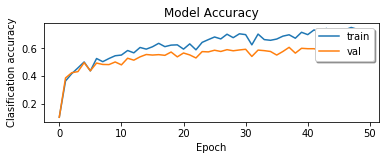

optimization: rmsprop filter_size: 5 filter_numbers: 96 batch_size: 96 learning_rate: 9e-05


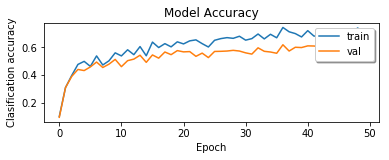

optimization: rmsprop filter_size: 5 filter_numbers: 96 batch_size: 96 learning_rate: 0.0001


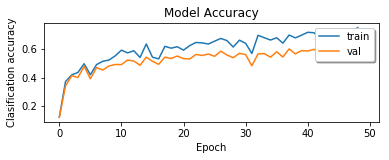

optimization: rmsprop filter_size: 5 filter_numbers: 128 batch_size: 96 learning_rate: 8e-05


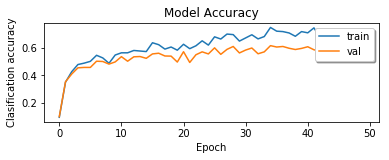

optimization: rmsprop filter_size: 5 filter_numbers: 128 batch_size: 96 learning_rate: 9e-05


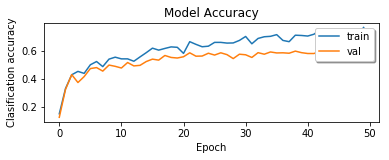

optimization: rmsprop filter_size: 5 filter_numbers: 128 batch_size: 96 learning_rate: 0.0001


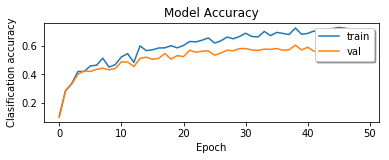

optimization: momentum filter_size: 5 filter_numbers: 96 batch_size: 96 learning_rate: 8e-05


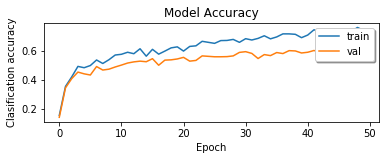

optimization: momentum filter_size: 5 filter_numbers: 96 batch_size: 96 learning_rate: 9e-05


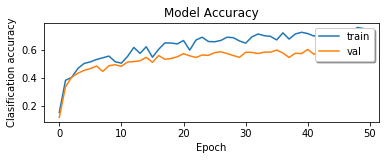

optimization: momentum filter_size: 5 filter_numbers: 96 batch_size: 96 learning_rate: 0.0001


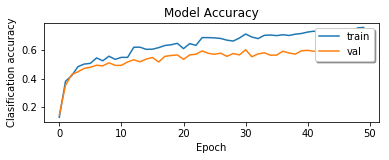

optimization: momentum filter_size: 5 filter_numbers: 128 batch_size: 96 learning_rate: 8e-05


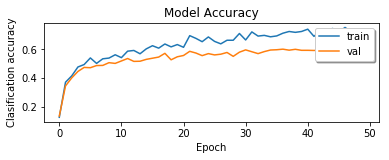

optimization: momentum filter_size: 5 filter_numbers: 128 batch_size: 96 learning_rate: 9e-05


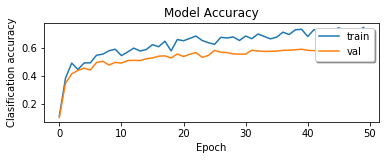

optimization: momentum filter_size: 5 filter_numbers: 128 batch_size: 96 learning_rate: 0.0001


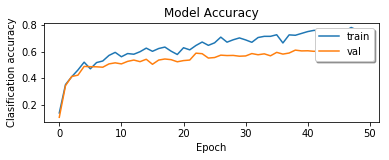

In [5]:
for opt in optimizations:
    for fs in filter_size:
        for fn in filter_numbers:
            for bs in batch_size:
                for lr in learning_rate:
                    loss_history, train_acc_history, val_acc_history = results[(opt, fs, fn, bs, lr)]
                    print "optimization: " + opt + " filter_size: " + str(fs) + " filter_numbers: " + str(fn) \
                          + " batch_size: " + str(bs) + " learning_rate: " + str(lr)
                    
                    plt.subplot(2, 1, 2)
                    plt.plot(results[opt, fs, fn, bs, lr][1], label='train')
                    plt.plot(results[opt, fs, fn, bs, lr][2], label='val')
                    plt.legend(loc='upper right', shadow=True)
                    plt.title('Model Accuracy')
                    plt.xlabel('Epoch')
                    plt.ylabel('Clasification accuracy')
                    plt.show()

In [6]:
# best net test score
test_loss, _ = two_layer_convnet(X_test, best_net, y_test)
print "Test loss: " + str(test_loss)

Test loss: 1.061267020698685


In [19]:
for filter_size in [5]: #, 7]:
    for filter_numbers in [96]: #, 64, 32]:
        for bath_size in [96]:#, 64, 32]:
            for lr in [1e-4]:#,1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
                print "filter_size: " + str(filter_size) + "filter_numbers" + str(filter_numbers) + " batch_size: " + str(bath_size) + " lr: " + str(lr)
                model = init_two_layer_convnet(filter_size=filter_size, num_filters=filter_numbers)
                trainer = ClassifierTrainer()
                best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
                      X_train, y_train, X_val, y_val, model, two_layer_convnet,
                      reg=0.001, momentum=0.9, learning_rate=lr, batch_size=bath_size, num_epochs=10,
                      acc_frequency=50, verbose=True)
                models.append(best_model)

filter_size: 5filter_numbers96 batch_size: 96 lr: 0.0001
starting iteration  0
Finished epoch 0 / 10: cost 2.296197, train: 0.147000, val 0.136000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 10: cost 1.796541, train: 0.334000, val 0.331000, lr 1.000000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 10: cost 1.507539, train: 0.453000, val 0.422000, lr 1.000000e-04
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 10: cost 1.642042, train: 0.471000, val 0.434000, lr 1.000000e-04
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
Finished epoch 1 / 10: cost 1.614903, train: 0.492000, val 0.454000, lr 9.500000e-05
starting iteration  200
Finished epoch 1 / 10: co

starting iteration  1780
starting iteration  1790
starting iteration  1800
Finished epoch 9 / 10: cost 0.600270, train: 0.699000, val 0.589000, lr 6.302494e-05
starting iteration  1810
starting iteration  1820
starting iteration  1830
starting iteration  1840
starting iteration  1850
Finished epoch 9 / 10: cost 0.644251, train: 0.715000, val 0.602000, lr 6.302494e-05
starting iteration  1860
starting iteration  1870
starting iteration  1880
starting iteration  1890
starting iteration  1900
Finished epoch 9 / 10: cost 0.773522, train: 0.732000, val 0.600000, lr 6.302494e-05
starting iteration  1910
starting iteration  1920
starting iteration  1930
starting iteration  1940
starting iteration  1950
Finished epoch 9 / 10: cost 0.743321, train: 0.738000, val 0.585000, lr 6.302494e-05
starting iteration  1960
Finished epoch 10 / 10: cost 0.699226, train: 0.729000, val 0.585000, lr 5.987369e-05
finished optimization. best validation accuracy: 0.616000


In [7]:
models = []
for filter_size in [5]: #, 7]:
    for filter_numbers in [128]: #, 64, 32]:
        for bath_size in [96]:#, 64, 32]:
            for lr in [9e-5]:#,1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
                print "filter_size: " + str(filter_size) + "filter_numbers" + str(filter_numbers) + " batch_size: " + str(bath_size) + " lr: " + str(lr)
                model = init_two_layer_convnet(filter_size=filter_size, num_filters=filter_numbers)
                trainer = ClassifierTrainer()
                best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
                      X_train, y_train, X_val, y_val, model, two_layer_convnet,
                      reg=0.001, momentum=0.9, learning_rate=lr, batch_size=bath_size, num_epochs=10,
                      acc_frequency=50, verbose=True)
                models.append(best_model)

filter_size: 5filter_numbers128 batch_size: 96 lr: 9e-05
starting iteration  0
Finished epoch 0 / 10: cost 2.304581, train: 0.101000, val 0.105000, lr 9.000000e-05
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 10: cost 1.923586, train: 0.369000, val 0.357000, lr 9.000000e-05
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 10: cost 1.675619, train: 0.417000, val 0.418000, lr 9.000000e-05
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 10: cost 1.583351, train: 0.456000, val 0.454000, lr 9.000000e-05
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
Finished epoch 1 / 10: cost 1.616786, train: 0.461000, val 0.437000, lr 8.550000e-05
starting iteration  200
Finished epoch 1 / 10: co

starting iteration  1780
starting iteration  1790
starting iteration  1800
Finished epoch 9 / 10: cost 0.844723, train: 0.690000, val 0.579000, lr 5.672245e-05
starting iteration  1810
starting iteration  1820
starting iteration  1830
starting iteration  1840
starting iteration  1850
Finished epoch 9 / 10: cost 0.819562, train: 0.760000, val 0.618000, lr 5.672245e-05
starting iteration  1860
starting iteration  1870
starting iteration  1880
starting iteration  1890
starting iteration  1900
Finished epoch 9 / 10: cost 0.561136, train: 0.757000, val 0.598000, lr 5.672245e-05
starting iteration  1910
starting iteration  1920
starting iteration  1930
starting iteration  1940
starting iteration  1950
Finished epoch 9 / 10: cost 0.842384, train: 0.727000, val 0.612000, lr 5.672245e-05
starting iteration  1960
Finished epoch 10 / 10: cost 0.775040, train: 0.741000, val 0.618000, lr 5.388632e-05
finished optimization. best validation accuracy: 0.618000


In [3]:
models = []
for filter_size in [5]: #, 5, 7]:
    for filter_numbers in [256]: #, 64, 32]:
        for bath_size in [96]:#, 64, 32]:
            for lr in [8e-5]:#,1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
                print "filter_size: " + str(filter_size) + " filter_numbers" + str(filter_numbers) + " batch_size: " + str(bath_size) + " lr: " + str(lr)
                model = init_two_layer_convnet(filter_size=filter_size, num_filters=filter_numbers)
                trainer = ClassifierTrainer()
                best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
                      X_train, y_train, X_val, y_val, model, two_layer_convnet,
                      reg=0.001, momentum=0.9, learning_rate=lr, batch_size=bath_size, num_epochs=10,
                      acc_frequency=50, verbose=True)
                models.append(best_model)

filter_size: 5 filter_numbers256 batch_size: 96 lr: 8e-05
starting iteration  0
Finished epoch 0 / 10: cost 2.291421, train: 0.087000, val 0.102000, lr 8.000000e-05
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 0 / 10: cost 1.772008, train: 0.379000, val 0.354000, lr 8.000000e-05
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 10: cost 1.496282, train: 0.469000, val 0.416000, lr 8.000000e-05
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
Finished epoch 0 / 10: cost 1.317702, train: 0.503000, val 0.454000, lr 8.000000e-05
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
Finished epoch 1 / 10: cost 1.298644, train: 0.512000, val 0.457000, lr 7.600000e-05
starting iteration  200
Finished epoch 1 / 10: c

starting iteration  1780
starting iteration  1790
starting iteration  1800
Finished epoch 9 / 10: cost 0.906259, train: 0.708000, val 0.571000, lr 5.041995e-05
starting iteration  1810
starting iteration  1820
starting iteration  1830
starting iteration  1840
starting iteration  1850
Finished epoch 9 / 10: cost 1.066516, train: 0.739000, val 0.604000, lr 5.041995e-05
starting iteration  1860
starting iteration  1870
starting iteration  1880
starting iteration  1890
starting iteration  1900
Finished epoch 9 / 10: cost 0.868500, train: 0.753000, val 0.593000, lr 5.041995e-05
starting iteration  1910
starting iteration  1920
starting iteration  1930
starting iteration  1940
starting iteration  1950
Finished epoch 9 / 10: cost 0.890868, train: 0.729000, val 0.600000, lr 5.041995e-05
starting iteration  1960
Finished epoch 10 / 10: cost 0.690570, train: 0.775000, val 0.603000, lr 4.789896e-05
finished optimization. best validation accuracy: 0.618000
